# Modeling the Quanser Qube Servo

The Qube Servo in pendulum configuration is a two-link planar manipulator with a revolutes joint at the base and "elbow". The first link is actuated by a motor, while the second link is free to rotate. If the rotor angle is $\theta$ and the pendulum angle is $\alpha$ (with zero in the "down" equilibrium position), the equations of motion in canonical "manipulator" form are

$$
% Mass matrix
\begin{bmatrix}
J_r + J_p \sin^2(\alpha) & -m_p \ell L_r \cos \alpha \\ 
-m_p \ell L_r \cos \alpha & J_p
\end{bmatrix}
\begin{bmatrix}
\ddot{\theta} \\ 
\ddot{\alpha}
\end{bmatrix}

+

% Coriolis matrix
\begin{bmatrix}
J_p \dot{\alpha} \sin 2 \alpha + b_r & m_p \ell L_r \dot{\alpha} \sin \alpha \\ 
-(1/2) J_p \dot{\theta} \sin 2 \alpha & b_p
\end{bmatrix}
\begin{bmatrix}
\dot{\theta} \\
\dot{\alpha}
\end{bmatrix}

+ 

% Gravity vector
\begin{bmatrix}
0 \\ m_p \ell g \sin \alpha
\end{bmatrix}

=

% Torque vector
\begin{bmatrix}
k_m / R_m \\ 0
\end{bmatrix}
u,
$$

where $R_m$ and $k_m$ approximately translate the input voltage $u$ to motor torque, $m_r$ and $m_p$ are the masses of the rotor and pendulum arms, $L_r$ and $L_p$ are the lengths of the rotor and pendulum arms, $\ell = L_p / 2$ is the center of mass of the pendulum arm, $b_r$ and $b_p$ are damping constants, $g$ is the gravitational constant, $J_r = m_r L_r^2 / 3$ is the moment of inertia of the rotor arm about the motor joint, and $J_p = m_p L_p^2 / 3$ is the moment of inertia of the pendulum about the pivot.

Furthermore, the Qube Servo has a weak restoring force from the connector cable that gradually returns the rotor to the "home" position.  We can model this in simulation with an additional proportional control on the rotor position $\theta$, so that given a command voltage $u'$, the torque input is

$$
u = u' - k_r \theta
$$

for a proportional gain $k_r$.  By default this gain is zero, but it can be set to a positive value to simulate the effect of the built-in controller.

These equations of motion are implemented in the `Qube` block in the form

$$
M(q) \ddot{q} + C(q, \dot{q}) \dot{q} + \tau_g(q) = B u,
$$

where $q = [\theta, \alpha]^T$, $M(q)$ is the mass matrix, $C(q, \dot{q})$ is the Coriolis matrix, $\tau_g(q)$ is the gravity vector, and $B$ is the input matrix.  The `Qube` block also includes the proportional control on the rotor position.

In [1]:
from functools import partial
import pickle
import sys, os

import numpy as np

import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from scipy.optimize import minimize

import collimator
from collimator import library
from collimator.library.quanser import animate_qube

from controllers import *

# Set to your ffmpeg path
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

# Include the quanser Python library (needed for connecting to hardware or QLabs)
HOME = os.path.expanduser("~")
sys.path.append(f"{HOME}/Quanser/libraries/python")

# Connect to physical hardware or QLabs simulation?
HARDWARE = True
version = 3 if HARDWARE else 2

%load_ext autoreload
%autoreload 2

# Simulating the system

First we will simulate the system with no control input, starting from a nonzero initial condition

collimator:INFO max_major_steps=200 by default since no discrete period in system
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=200, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=Qube(system_id=1, name='Qube_1_', ui_id=None, parent=None), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


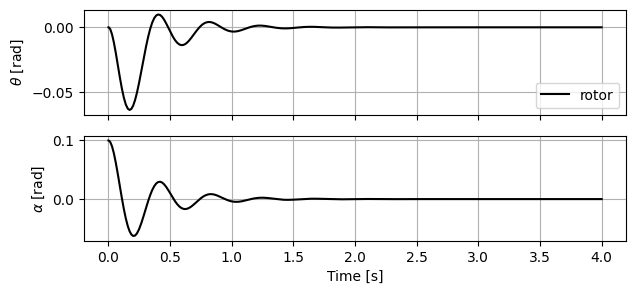

In [2]:

system = library.QubeServoModel(full_state_output=True)

# Since we are not applying control, fix the value of
# the input port
system.input_ports[0].fix_value(0.0)

context = system.create_context()

x0 = np.array([0.0, 0.1, 0.0, 0.0])
context = context.with_continuous_state(x0)

recorded_signals = {
    "x": system.output_ports[0],
}

tf = 4.0
results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["x"][:, 0], 'k', label="rotor")
ax[0].set_ylabel(r"$\theta$ [rad]")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["x"][:, 1], 'k', label="pendulum")
ax[1].set_ylabel(r"$\alpha$ [rad]")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()

In [5]:
# Simple animation with matplotlib

t = results.time
x = results.outputs["x"]

t_plt = np.linspace(t[0], t[-1], 200)
x_plt = np.zeros((len(t_plt), 4))
for i in range(2):
    x_plt[:, i] = np.interp(t_plt, t, x[:, i])

animate_qube(t_plt, x_plt, context.parameters)

Next we will add an input signal.  To see the response of the system to a simple input, we will apply a unit step input to the motor voltage for a duration of 100 ms.  We can do this with a simple combination of two `Step` blocks.

Note that the following `make_diagram` function includes some additional code for a "reference" signal.  We can ignore this for now, and will return to it when calibrating our analytic model.

collimator:INFO max_major_steps=100 based on smallest discrete period=inf
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


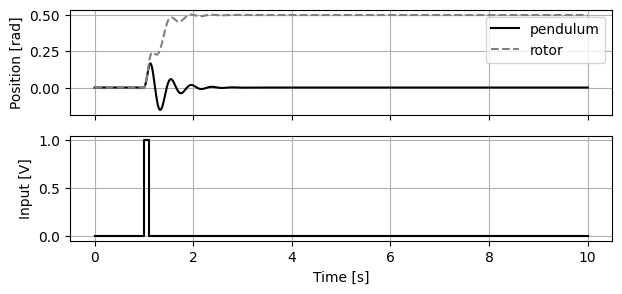

In [6]:
def make_diagram(plant, dt=1e-3, reference=None, name="root"):
    builder = collimator.DiagramBuilder()

    # Construct the input signal as the difference of two
    # unit step functions spaced 0.1 seconds apart
    pulse = make_pulse(amplitude=1.0, start_time=1.0, width=0.1)

    # Connect the adder block to the input port of the plant
    builder.add(pulse, plant)
    builder.connect(pulse.output_ports[0], plant.input_ports[0])

    if reference is not None:
        # Add a "reference" signal and track mean-squared error of the
        # model state against the reference signal
        error = library.Adder(2, operators="-+", name="error")
        squared_error = library.DotProduct(name="squared_error")
        mse = library.IntegratorDiscrete(dt, initial_state=0.0, name="mse")
        builder.add(reference, error, squared_error, mse)
        builder.connect(reference.output_ports[0], error.input_ports[0])
        builder.connect(plant.output_ports[0], error.input_ports[1])
        builder.connect(error.output_ports[0], squared_error.input_ports[0])
        builder.connect(error.output_ports[0], squared_error.input_ports[1])
        builder.connect(squared_error.output_ports[0], mse.input_ports[0])

    return builder.build(name=name)


tf = 10.0
plant = library.QubeServoModel()

system = make_diagram(plant)
context = system.create_context()

# Record time series signals of the input and output ports
recorded_signals = {
    "y": plant.output_ports[0],
    "u": plant.input_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)


fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["y"][:, 1], c='k', label="pendulum")
ax[0].plot(results.time, results.outputs["y"][:, 0], '--', c='grey', label="rotor")
ax[0].set_ylabel("Position [rad]")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["u"], c='k', label="pendulum")
ax[1].set_ylabel("Input [V]")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()

# Connecting to the hardware (HIL)

Next we can send the same input signal to the hardware (virtual or physical) and see how good our model is.  For this step you will either need to have QLabs running and open to the Qube Servo workspace, or have a physical Qube Servo connected with drivers installed (see Quanser website for instructions).  The `QuanserHAL` block will connect to the hardware and handle the timing so that the simulation will happen in real time.

In [5]:
dt = 1.0 / 1000  # Sampling rate (1 kHz)
tf = 5.0
plant_hw = library.QuanserHAL(dt=dt, hardware=HARDWARE, version=version, name="QuanserHAL")

system = make_diagram(plant_hw, dt)
context = system.create_context()

recorded_signals = {
    "y": plant_hw.output_ports[0],
    "u": plant_hw.input_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)

# Make sure to disconnect from the interface
system["QuanserHAL"].terminate()

# We will reuse these results for calibration, so 
# store them in separate variables
y_hw = results.outputs["y"]
t_hw = results.time

collimator:INFO max_major_steps=9998 based on smallest discrete period=0.001
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=9998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Initialized Qube
Restoring sigint handler


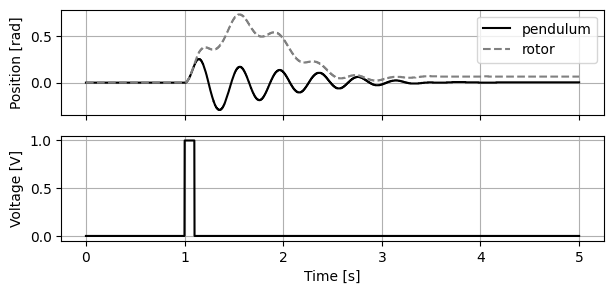

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["y"][:, 1], c='k', label="pendulum")
ax[0].plot(results.time, results.outputs["y"][:, 0], '--', c='grey', label="rotor")
ax[0].set_ylabel("Position [rad]")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["u"], c='k', label="voltage")
ax[1].set_ylabel("Voltage [V]")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()

# Calibrating the model

So far the correspondence between the virtual hardware and the analyic model is fairly poor.  The rotor returns to zero in the vHIL simulation and not in the analytic simulation, since we did not include the built-in proportional control on the rotor.  More importantly, the damping constants are clearly not correct, since the transients take much longer to die down in the vHIL simulation compared to the first case.

However, we can use the data from the vHIL simulation as "ground truth" to calibrate the model.  This is where we will use the reference functionality in `make_diagram`.  This signal will use lookup tables to interpolate the vHIL data and provide a reference signal to the analytic model.  We will accumulate the squared error between the reference signal and the analytic signal, and use this as the cost function to minimize.  The reference signal construction can all be done in a subdiagram and passed to `make_diagram`; we'll do this in a new function `make_reference`.

collimator:INFO max_major_steps=9998 based on smallest discrete period=0.001
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=9998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=3, return_context=True), Dopri5Solver(system=Diagram(root, 6 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


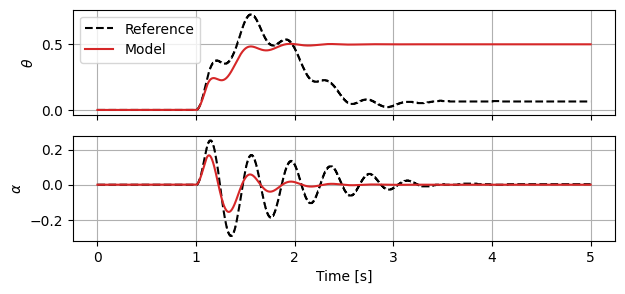

In [7]:
def make_reference(t, y, name="reference"):
    """Use multiple lookup tables to create a time-varying reference signal."""

    clock = library.Clock(name="clock")
    ref1 = library.LookupTable1d(t, y[:, 0], name="ref1", interpolation="linear")
    ref2 = library.LookupTable1d(t, y[:, 1], name="ref2", interpolation="linear")
    mux = library.Multiplexer(2, name="mux")
    builder = collimator.DiagramBuilder()
    builder.add(clock, ref1, ref2, mux)
    builder.connect(clock.output_ports[0], ref1.input_ports[0])
    builder.connect(clock.output_ports[0], ref2.input_ports[0])
    builder.connect(ref1.output_ports[0], mux.input_ports[0])
    builder.connect(ref2.output_ports[0], mux.input_ports[1])
    builder.export_output(mux.output_ports[0])

    return builder.build(name=name)

model_plant = library.QubeServoModel(full_state_output=False)
reference = make_reference(t_hw, y_hw, name="reference")

system = make_diagram(model_plant, dt, reference=reference)
context = system.create_context()

recorded_signals = {
    "y": model_plant.output_ports[0],
    "u": model_plant.input_ports[0],
    "r": reference.output_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["r"][:, 0], c='k', ls="--", label="Reference")
ax[0].plot(results.time, results.outputs["y"][:, 0], c='tab:red', label="Model")
ax[0].set_ylabel(r"$\theta$")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["r"][:, 1], c="k", ls="--")
ax[1].plot(results.time, results.outputs["y"][:, 1], c="tab:red")
ax[1].set_ylabel(r"$\alpha$")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()

We will calibrate the damping constants $b_r$ and $b_p$ and the proportional gain $k_r$ by solving the constrained optimization problem:

$$
\begin{gather*}
\min_{p} \int_0^T \left( y(t) - y_{\text{ref}}(t) \right)^2 \, dt \\
\text{subject to} \quad p \geq 0,
\end{gather*}
$$

where $p = [b_r, b_p, k_r]$ are the parameters to be optimized (constrained to be non-negative), $y(t)$ is the output of the analytic model, and $y_{\text{ref}}(t)$ is the reference signal.  We can use the `scipy.optimize.minimize` function to solve this problem, with automatic differentiation to compute the gradient of the cost function and the L-BFGS-B algorithm to handle the constraints.

In [8]:

model_plant = library.QubeServoModel(full_state_output=False)
reference = make_reference(t_hw, y_hw, name="reference")
system = make_diagram(model_plant, dt, reference=reference)
mse_id = system["mse"].system_id
context = system.create_context()
tf = 10.0

# Need to enable autodiff for the simulator (this uses static "while loop" bounds
# to allow for reverse-mode differentiation).
options = collimator.SimulatorOptions(enable_autodiff=True)

def forward(context, p):
    """Evaluate the objective via forward simulation"""

    br, bp, kr = p
    plant_context = context[model_plant.system_id].with_parameters(
        dict(br=br, bp=bp, kr=kr)
    )
    context = context.with_subcontext(model_plant.system_id, plant_context)

    results = collimator.simulate(
        system,
        context,
        (0.0, tf),
        options=options,
    )

    return results.context[mse_id].discrete_state

# JIT-compile the objective and its gradient using JAX
obj = jax.jit(partial(forward, context))
jac = jax.jit(jax.grad(obj))

# Solve the optimization problem with BFGS in SciPy
x0 = np.array([1e-3, 5e-5, 0.0])
res = minimize(
    obj,
    x0,
    jac=jac,
    method="L-BFGS-B",
    bounds=[(0.0, None), (0.0, None), (0.0, None)],
    options={"disp": True},
    tol=1e-10,
)
br, bp, kr = res.x


collimator:INFO max_major_steps=19998 based on smallest discrete period=0.001
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=19998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=Diagram(root, 6 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=True)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.49482D+00    |proj g|=  3.34184D+03

At iterate    1    f=  3.30397D-01    |proj g|=  9.64807D-03

At iterate    2    f=  3.30396D-01    |proj g|=  9.64779D-03

At iterate    3    f=  3.30396D-01    |proj g|=  9.64715D-03

At iterate    4    f=  3.30386D-01    |proj g|=  9.71790D-03

At iterate    5    f=  2.58992D-01    |proj g|=  1.14080D-02
  ys=-1.617E+00  -gs= 2.805E-03 BFGS update SKIPPED

At iterate    6    f=  2.05941D-01    |proj g|=  1.75173D+00

At iterate    7    f=  2.05838D-01    |proj g|=  5.45624D-01

At iterate    8    f=  2.05778D-01    |proj g|=  5.63468D-01

At iterate    9    f=  2.05376D-01    |proj g|=  2.04154D+00

At iterate   10    f=  2.04678D-01    |proj g|=  4.50313D+00

At iterate   11    f=  2.01539D-01    |proj g|=  1.41969D+01

At iterate   12    f=  1.93681D-01  

Finally, we can compare the calibrated model to the hardware to see how well we did.

br = 6.0226e-04, bp = 0.0000e+00, kr = 1.9013e-01


collimator:INFO max_major_steps=19998 based on smallest discrete period=0.001
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=19998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=3, return_context=True), Dopri5Solver(system=Diagram(root, 6 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


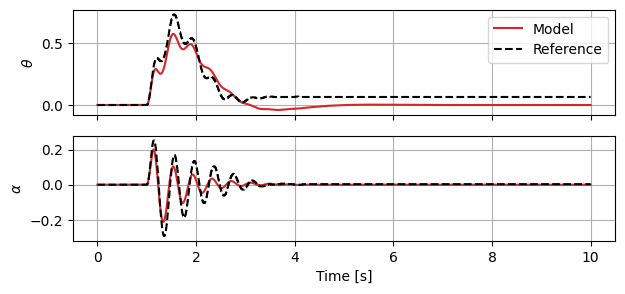

In [9]:
print(f"br = {br:.4e}, bp = {bp:.4e}, kr = {kr:.4e}")

model_plant = library.QubeServoModel(br=br, bp=bp, kr=kr, full_state_output=False)
reference = make_reference(t_hw, y_hw, name="reference")

system = make_diagram(model_plant, dt, reference=reference)
context = system.create_context()

recorded_signals = {
    "y": model_plant.output_ports[0],
    "u": model_plant.input_ports[0],
    "r": reference.output_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["y"][:, 0], c='tab:red', label="Model")
ax[0].plot(results.time, results.outputs["r"][:, 0], c='k', ls="--", label="Reference")
ax[0].set_ylabel(r"$\theta$")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["y"][:, 1], c="tab:red")
ax[1].plot(results.time, results.outputs["r"][:, 1], c="k", ls="--")
ax[1].set_ylabel(r"$\alpha$")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()